# CIFAR-10 Image Classification using GUNN-15 (Gradually Updated Neural Networks for Large-Scale Image Recognition)

#### Author: Aishwarya Radhakrishnan
#### Date: April 10, 2020

## Abstract / Introduction

*Convolutional Neural Networks(CNNs) decreases the computation cost for Computer Vision problems than the Deep Neural Networks(DNNs). Increasing the depth leads to increase in parameters of the CNN and hence, increase in computation cost. But as depth plays a vital role in Computer Vision problems, increasing the depth without increasing the computation cost can lead to increased learning. This is achieved by introducing
computation orderings to the channels within convolutional layers.*

*Gradually Updated Neural Networks (GUNN) as opposed to the default Simultaneously Updated Convolutional Network (SUNN / CNN), gradually updates the feature representations against the
traditional convolutional network that computes its output
simultaneously.  This is achieved by updating one channel at a time and using the newly computed parameter of this channel and old parameter of other channels to get another channels in a single convolutional layer. This is repeated for all the channels untill all the old parameters of a single convolutional layer are updated to new values. Thus a single convolutional layer is broken down into multiple gradually updated convolutional layer.*




## Prerequisites

sudo yum install python-pip

sudo pip install keras

sudo pip install tensorflow

sudo pip install numpy


In [2]:
import keras
from tensorflow.keras.datasets import cifar10
import numpy as np
import os
from tensorflow.keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D

from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras import metrics


import tensorflow as tf

tf.keras.backend.clear_session()  # For easy reset of notebook state.

print(tf.__version__)

import tensorflow.keras.backend as K
K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

%matplotlib inline

Using TensorFlow backend.


2.2.0-rc2


## Loading CIFAR-10 Dataset

In [3]:

(X_train_orig, Y_train_orig), (X_test_orig, Y_test_orig) = cifar10.load_data()
X_train_orig = X_train_orig.astype('float32')
X_test_orig = X_test_orig.astype('float32')

# Normalize image vectors
mean = np.mean(X_train_orig,axis=(0,1,2,3))
std = np.std(X_train_orig, axis=(0, 1, 2, 3))
X_train = (X_train_orig-mean)/(std+1e-7)
X_test = (X_test_orig-mean)/(std+1e-7)
#X_train = X_train_orig/255.
#X_test = X_test_orig/255.

Y_train = keras.utils.to_categorical(Y_train_orig, 10)
Y_test = keras.utils.to_categorical(Y_test_orig, 10)

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 50000
number of test examples = 10000
X_train shape: (50000, 32, 32, 3)
Y_train shape: (50000, 10)
X_test shape: (10000, 32, 32, 3)
Y_test shape: (10000, 10)


In [0]:
#X_train = X_train[:100]
#Y_train = Y_train[:100]
#X_test = X_test[:10]
#Y_test = Y_test[:10]

<figure>
<center>
<img src='https://drive.google.com/uc?id=1Cn19zTjlJEdYo-EjeGRjPOK9ol_wxfuV' />
<figcaption>CIFAR 10 dataset with 10 classes</figcaption></center>
</figure>


# GUNN Layer implementation (Keras Custom Layer)

In [0]:
def conv_forward(A_shortcut, W1, b1, W2, b2, W3, b3, hparameters):
    """
    Implements the forward propagation for a convolution function
    
    Arguments:
    A_shortcut -- output activations of the previous layer, input to this layer, numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    W -- Weights, numpy array of shape (f, f, n_C_prev, n_C)
    b -- Biases, numpy array of shape (1, 1, 1, n_C)
    hparameters -- python dictionary containing "stride" and "pad"
        
    Returns:
    A -- conv output, numpy array of shape (m, n_H, n_W, n_C)
    """
    expand = hparameters["expand"]
    channels = hparameters["channels"]
    depth_batch = channels // expand

    """
    Using conv2d for 1 step of gradual update. 
    Gradually updating by taking `depth_batch` steps of `expand` channels at a time.
    Note: if you dont add b or not use a registered parameter, tensorflow will give error as follows:
    Gradients do not exist for variables ['layer/Variable:0'] when minimizing the loss
    """
    A = tf.identity(A_shortcut)
    for i in range(depth_batch):
        Z = tf.nn.conv2d(A, W1, [1, 1, 1, 1], "VALID") + b1
        A = tf.concat([A[:, :, :, :i*expand ], Z, A[:, :, :, i*expand + expand : ]], 3)
    #A = BatchNormalization(axis = 3 , name = 'Gunn_BN_1')(A)
    A = Activation('relu')(A)
  
    for i in range(depth_batch):
        Z = tf.nn.conv2d(A, W2, [1, 1, 1, 1], "SAME") + b2
        A = tf.concat([A[:, :, :, :i*expand ], Z, A[:, :, :, i*expand + expand : ]], 3)
    #A = BatchNormalization(axis = 3 , name = 'Gunn_BN_2')(A)
    A = Activation('relu')(A)

    for i in range(channels):
        Z = tf.nn.conv2d(A, W3, [1, 1, 1, 1], "VALID") + b3
        A = tf.concat([A[:, :, :, :i ], Z, A[:, :, :, i + 1 : ]], 3)
    #A = BatchNormalization(axis = 3 , name = 'Gunn_BN_3')(A)

    # Add shortcut value to main path. This implements the identity block in Residual Network.
    A = Add()([A , A_shortcut])
    print('Resnet : {}'.format(A.shape))

    return A



class Gunn2D(layers.Layer):
  """Implementation of my own keras layer since the GUNN layer has custom operations having trainable weights.

    __init__(): Input parameters to layer
    build(input_shape) : Weights of Gunn2D layer are defined. Besides trainable weights, you can add non-trainable weights to a layer as well. Such weights are meant not to be taken into account during backpropagation, when you are training the layer.
    call(x) : This is where you write your forward propagation logic. 

    Attributes:
        self.input_channels (int): Input to this layer's number of channels which is not changed by Gunn2D layer.
        self.expansion_rate (int, optional): Update weights of these many channels at once using the whole input.
  """

  def __init__(self, input_channels, expansion_rate=100):
    super(Gunn2D, self).__init__()
    self.input_channels = input_channels
    self.expansion_rate = expansion_rate
    self.hparameters = {"expand": self.expansion_rate, "channels": self.input_channels}

  def build(self, input_shape):
    self.w1 = self.add_weight(shape=(1, 1, self.input_channels, self.expansion_rate), initializer='random_normal', trainable=True)
    self.b1 = self.add_weight(shape=(1, 1, 1, self.expansion_rate), initializer='random_normal', trainable=True)
    self.w2 = self.add_weight(shape=(3, 3, self.input_channels, self.expansion_rate), initializer='random_normal', trainable=True)
    self.b2 = self.add_weight(shape=(1, 1, 1, self.expansion_rate), initializer='random_normal', trainable=True)
    self.w3 = self.add_weight(shape=(1, 1, self.input_channels, 1), initializer='random_normal', trainable=True)
    self.b3 = self.add_weight(shape=(1, 1, 1, 1), initializer='random_normal', trainable=True)

  def call(self, inputs):
    output = conv_forward(inputs, self.w1, self.b1, self.w2, self.b2, self.w3, self.b3, self.hparameters)
    return output 



## Building GUNN-15 Model in Keras for 10 classes of CIFAR-10 dataset

In [0]:
def GunnModel(input_shape):
    """
    Implementation of the GUNN-15 Model.

    GunnModel implements image classification model for CIFAR-10 dataset.

    Gunn2D is used to replace convolutional layers. Residual Networks principles are also used in Gunn2D layer.
    Conv2D is used for Convolutional Neural Networks - Forward and Backward pass
    BatchNormalization and Activation are used.
    
    Arguments:
    input_shape -- shape of the images of the dataset

    Returns:
    model -- a Model() instance in Keras
    """
    
    print("input_shape: {}".format(input_shape))
    X_input = Input(input_shape)
    print("X_input: {}".format(X_input.shape))
    #frozen = VGG16 (weights="imagenet", input_shape=(32,32,3), include_top=False)
    #trainable = frozen.output
    X = Conv2D(64, (3, 3), strides = (1, 1), padding='same', name = 'z1')(X_input) # 32x32x3 -> 32x32x64   ; padding = 1
    X = BatchNormalization(axis = 3 , name = 'bn1')(X)
    X = Activation('relu')(X)
    convlayer = Conv2D(240, (1, 1), strides = (1, 1), padding='valid', name = 'z2')
    X = convlayer(X) # 32x32x64 -> 32x32x240
    layer = BatchNormalization(axis = 3 , name = 'bn2')
    X = layer(X)
    X = Activation('relu')(X)
    print('After Activation : {}'.format(X))
    X = Gunn2D(240, 20)(X) # custom Keras layer class
    print('After Gunn2D : {}'.format(X))
    X = Conv2D(300, (1, 1), strides = (1, 1), padding='valid', name = 'z3')(X)
    print('After Conv2D : {}'.format(X))
    X = BatchNormalization(axis = 3 , name = 'bn3')(X)
    print('After BN : {}'.format(X))
    X = Activation('relu')(X)
    print('After Activation : {}'.format(X))
    X = AveragePooling2D((2, 2), name = 'avg_pool1')(X)
    print('After AveragePooling2D : {}'.format(X))
    X = Gunn2D(300, 20)(X)
    print('After Gunn2D 2 : {}'.format(X))
    print(X)
    X = Conv2D(360, (1, 1), strides = (1, 1), padding='valid', name = 'z4')(X)
    X = BatchNormalization(axis = 3 , name = 'bn4')(X)
    X = Activation('relu')(X)
    X = AveragePooling2D((2, 2), name = 'avg_pool2')(X)
    print(X)
    X = Gunn2D(360, 20)(X)
    print('After Gunn2D 3 : {}'.format(X))
    print(X)
    X = Conv2D(360, (1, 1), strides = (1, 1), padding='valid', name = 'z5')(X)
    X = BatchNormalization(axis = 3 , name = 'bn5')(X)
    X = Activation('relu')(X)
    X = AveragePooling2D((8, 8), name = 'avg_pool3')(X)
    print('After AveragePooling2D : {}'.format(X))
    X = Flatten()(X)
    print('After Flatten : {}'.format(X))
    X = Dense(360, activation='softmax', name = 'fc1')(X)
    X = Dense(360, activation='softmax', name = 'fc2')(X)
    X = Dense(10, activation='softmax', name = 'fc3')(X)
    print('After Dense : {}'.format(X))

    model = Model(inputs = X_input, outputs = X, name = 'GUNN-15-Model')
    print(model)
    return model

## Fit model on small CIFAR-10 dataset

In [9]:

#gunnModel = GunnModel(X_train.shape[1:])
#gunnModel.compile(optimizer = "adam", loss='categorical_crossentropy', metrics=[metrics.categorical_accuracy])
#gunnModel.fit(x = X_train , y = Y_train, epochs = 5, steps_per_epoch = (X_train.shape[0]//10))
#preds = gunnModel.evaluate(x=X_test, y=Y_test)
#print()
#print ("Loss = " + str(preds[0]))
#print ("Test Accuracy = " + str(preds[1]))

input_shape: (32, 32, 3)
X_input: (None, 32, 32, 3)
After Activation : Tensor("activation_6/Identity:0", shape=(None, 32, 32, 240), dtype=float32)
Resnet : (None, 32, 32, 240)
After Gunn2D : Tensor("gunn2d_3/Identity_1:0", shape=(None, 32, 32, 240), dtype=float32)
After Conv2D : Tensor("z3_1/Identity:0", shape=(None, 32, 32, 300), dtype=float32)
After BN : Tensor("bn3_1/Identity:0", shape=(None, 32, 32, 300), dtype=float32)
After Activation : Tensor("activation_7/Identity:0", shape=(None, 32, 32, 300), dtype=float32)
After AveragePooling2D : Tensor("avg_pool1_1/Identity:0", shape=(None, 16, 16, 300), dtype=float32)
Resnet : (None, 16, 16, 300)
After Gunn2D 2 : Tensor("gunn2d_4/Identity_1:0", shape=(None, 16, 16, 300), dtype=float32)
Tensor("gunn2d_4/Identity_1:0", shape=(None, 16, 16, 300), dtype=float32)
Tensor("avg_pool2_1/Identity:0", shape=(None, 8, 8, 360), dtype=float32)
Resnet : (None, 8, 8, 360)
After Gunn2D 3 : Tensor("gunn2d_5/Identity_1:0", shape=(None, 8, 8, 360), dtype=flo

## Fit model on complete CIFAR-10 dataset

In [0]:
gunnModel = GunnModel(X_train.shape[1:])
gunnModel.compile(optimizer = "adam", loss='categorical_crossentropy', metrics=[metrics.categorical_accuracy])
gunnModel.fit(x = X_train , y = Y_train, epochs = 500, steps_per_epoch = (X_train.shape[0]//100), callbacks=[cp_callback])
preds = gunnModel.evaluate(x=X_test, y=Y_test)
print()
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

input_shape: (32, 32, 3)
X_input: (None, 32, 32, 3)
After Activation : Tensor("activation_1/Identity:0", shape=(None, 32, 32, 240), dtype=float32)
Resnet : (None, 32, 32, 240)
After Gunn2D : Tensor("gunn2d/Identity_1:0", shape=(None, 32, 32, 240), dtype=float32)
After Conv2D : Tensor("z3/Identity:0", shape=(None, 32, 32, 300), dtype=float32)
After BN : Tensor("bn3/Identity:0", shape=(None, 32, 32, 300), dtype=float32)
After Activation : Tensor("activation_2/Identity:0", shape=(None, 32, 32, 300), dtype=float32)
After AveragePooling2D : Tensor("avg_pool1/Identity:0", shape=(None, 16, 16, 300), dtype=float32)
Resnet : (None, 16, 16, 300)
After Gunn2D 2 : Tensor("gunn2d_1/Identity_1:0", shape=(None, 16, 16, 300), dtype=float32)
Tensor("gunn2d_1/Identity_1:0", shape=(None, 16, 16, 300), dtype=float32)
Tensor("avg_pool2/Identity:0", shape=(None, 8, 8, 360), dtype=float32)
Resnet : (None, 8, 8, 360)
After Gunn2D 3 : Tensor("gunn2d_2/Identity_1:0", shape=(None, 8, 8, 360), dtype=float32)
Tens

In [10]:
gunnModel.summary()

Model: "GUNN-15-Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
z1 (Conv2D)                  (None, 32, 32, 64)        1792      
_________________________________________________________________
bn1 (BatchNormalization)     (None, 32, 32, 64)        256       
_________________________________________________________________
activation_5 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
z2 (Conv2D)                  (None, 32, 32, 240)       15600     
_________________________________________________________________
bn2 (BatchNormalization)     (None, 32, 32, 240)       960       
_________________________________________________________________
activation_6 (Activation)    (None, 32, 32, 240)     

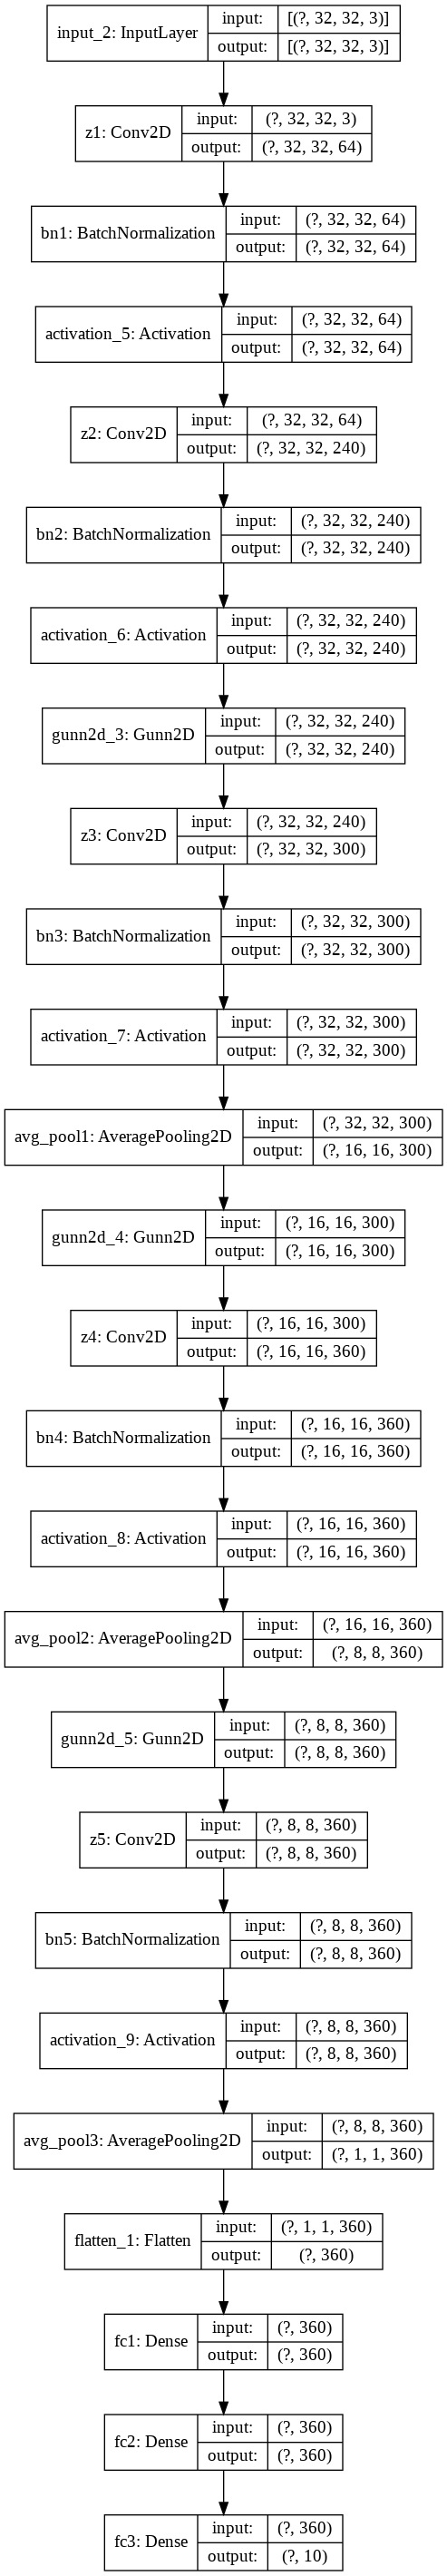

In [11]:
tf.keras.utils.plot_model(gunnModel, 'gunnModel_model.png', show_shapes=True)